# Regression Imputation 

For regression imputation, we will use a regression analysis to predict missing IPC values based on other variables (in this case, the other variables were chosen from those most correlated with IPC - year, district_code, food_price_idx, pasture_pct). We will also do it for each administrative region separately so that the accuracy is better.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
file_path = '/Users/Isha/Desktop/TUe/Year 3/Quarter 1 Y3/Data Challenge 3/DC3/data/food_crises_updated.csv'
df = pd.read_csv(file_path)
print(len(df)) # gives number of total enteries

12324


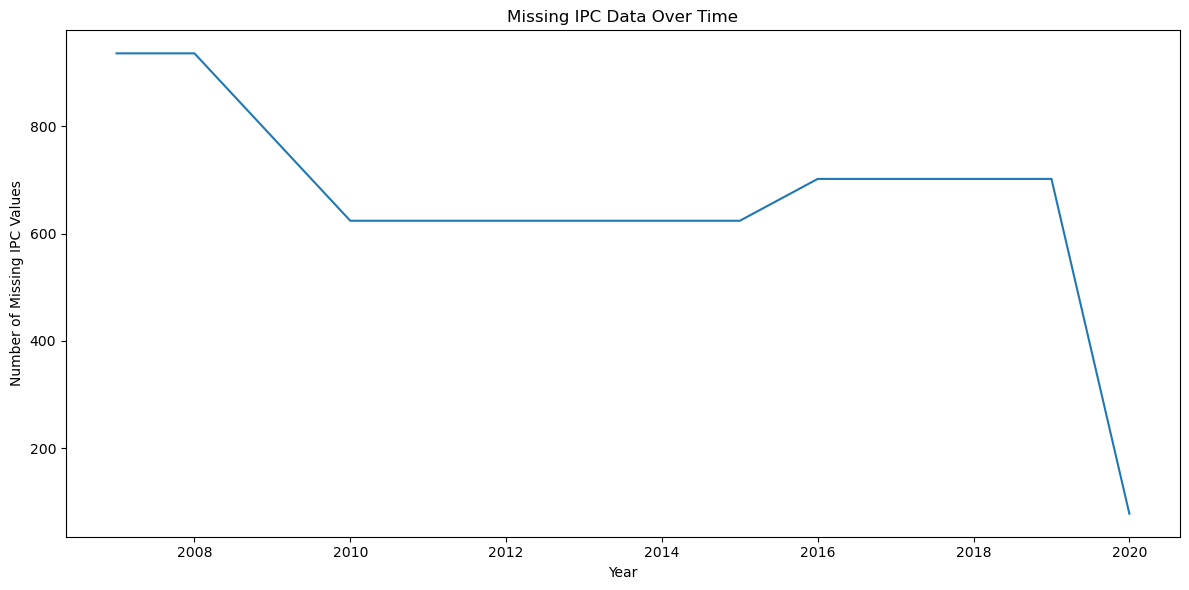

In [2]:
# Check missing data pattern for a specific column (e.g., 'IPC')
# Assuming 'IPC' is the column containing IPC data
ipc_missing_pattern = df['ipc'].isnull().sum()

# Analyze the pattern further, consider time-based analysis
# Example: Check if missing data has a pattern linearly with time
# Assuming a time-related column (e.g., 'date')
# Replace 'date' with the actual time-related column in dataset
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Group by year and count missing IPC values for each year
missing_by_year = df.groupby('year')['ipc'].apply(lambda x: x.isnull().sum())

# Plot the missing data pattern over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=missing_by_year.index, y=missing_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Missing IPC Values')
plt.title('Missing IPC Data Over Time')
plt.tight_layout()
plt.show()

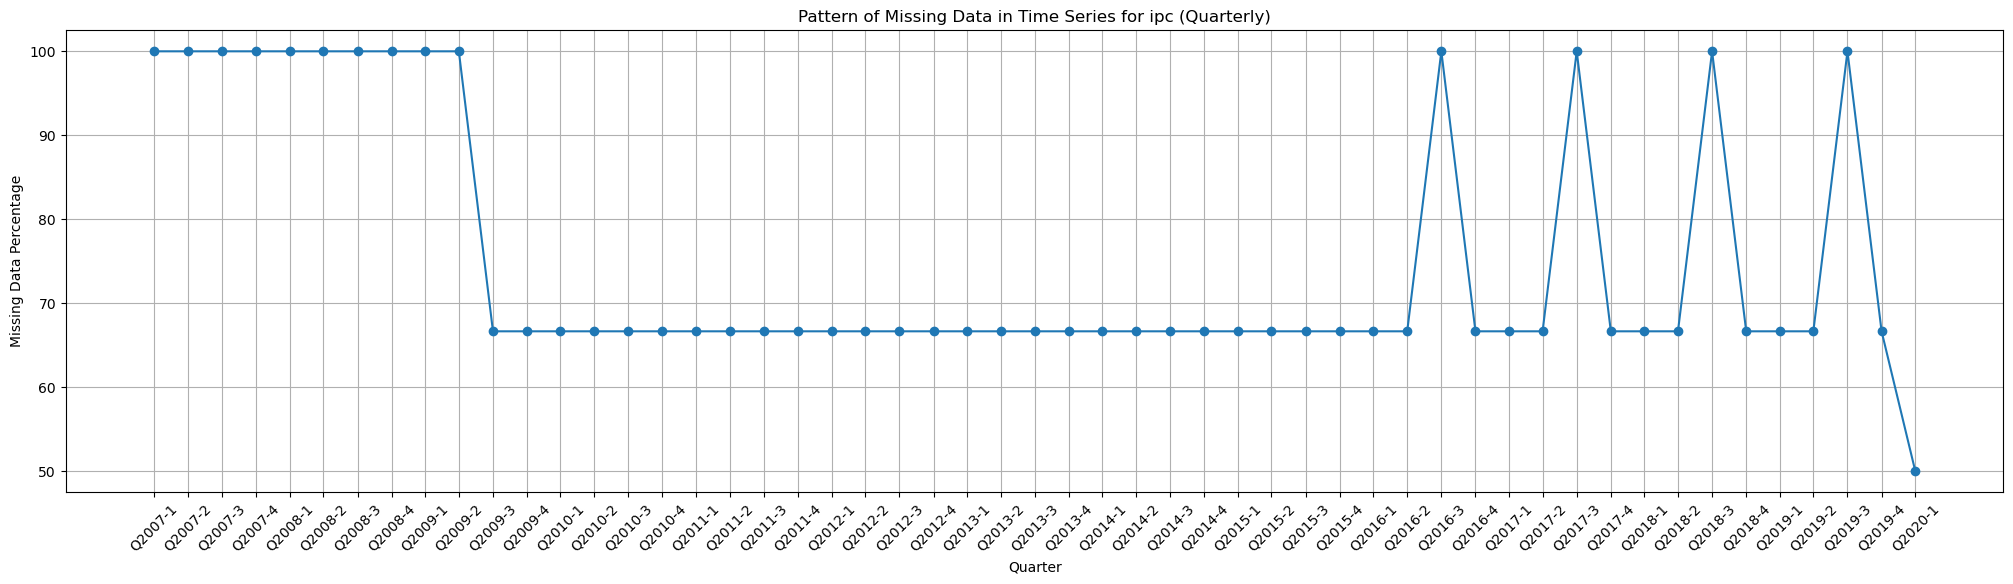

In [3]:
# Convert 'year_month' to datetime and set it as the index
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y_%m')
df.set_index('year_month', inplace=True)

# Calculate the missing data percentage for each quarter
missing_data_percentage = df['ipc'].isnull().astype(int).resample('Q').mean() * 100
quarters = [f'Q{quarter.year}-{quarter.quarter}' for quarter in missing_data_percentage.index]

# Plot the missing data percentage over time (quarterly)
plt.figure(figsize=(25, 6))
plt.plot(missing_data_percentage.index, missing_data_percentage.values, marker='o', linestyle='-')
plt.xticks(missing_data_percentage.index, quarters, rotation=45)  # Set custom x-labels and rotate for readability
plt.xlabel('Quarter')
plt.ylabel('Missing Data Percentage')
plt.title('Pattern of Missing Data in Time Series for ipc (Quarterly)')
plt.grid()
plt.show()

# Extract the quarter from the 'year_month' column
df['quarters'] = df.index.to_period('Q')


In [4]:
# Select columns with numerical data types
numerical_columns = df.select_dtypes(include=['number']).columns

# Print the numerical column names
print("Numerical columns:")
print(numerical_columns)

Numerical columns:
Index(['Unnamed: 0', 'district_code', 'centx', 'centy', 'year', 'month', 'ipc',
       'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct'],
      dtype='object')


In [5]:
# Extracts the unique values from the 'administrative_region' column of the DataFrame
unique_regions = df['administrative_region'].unique()
print('Unique administrative regions:', unique_regions)
print(df['quarters'].head())

Unique administrative regions: ['Greater Upper Nile' 'Bahr El Ghazal' 'Equatoria']
year_month
2007-01-01    2007Q1
2007-02-01    2007Q1
2007-03-01    2007Q1
2007-04-01    2007Q2
2007-05-01    2007Q2
Name: quarters, dtype: period[Q-DEC]


In [6]:
# Calculate the percentage of missing values for the column of interest
missing_percentage = (df['ipc'].isnull().sum() / len(df)) * 100
print(f"Percentage of missing values in ipc: {missing_percentage:.2f}%")

Percentage of missing values in ipc: 75.32%


#### Sorting out the unique district codes in Greater Upper Nile, Bahr El Ghazal, Equatoria for further usage in IPC imputation region-wise:

In [7]:
## GREAT UPPER NILE
# Initialize a set to store district codes for Greater Upper Nile (ensures uniqueness)
district_codes_nile_set = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    if row['administrative_region'] == 'Greater Upper Nile':
        district_codes_nile_set.add(row['district_code'])

# Convert the set back to a list (to maintain the original list data type)
district_codes_in_nile = list(district_codes_nile_set)

# Print the unique district codes in Greater Upper Nile
print('Unique District codes in Greater Upper Nile:', district_codes_in_nile)

Unique District codes in Greater Upper Nile: [130, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 146, 147, 148, 149, 150, 151, 74, 104, 109, 111, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127]


In [8]:
## BAHR EL GHAZAL
# Initialize a set to store district codes for Bahr El Ghazal (ensures uniqueness)
district_codes_bahr_set = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    if row['administrative_region'] == 'Bahr El Ghazal':
        district_codes_bahr_set.add(row['district_code'])

# Convert the set back to a list (to maintain the original list data type)
district_codes_in_bahr = list(district_codes_bahr_set)

# Print the unique district codes in Bahr El Ghazal
print('Unique District codes in Bahr El Ghazal:', district_codes_in_bahr)


Unique District codes in Bahr El Ghazal: [128, 129, 131, 132, 133, 141, 145, 75, 76, 99, 101, 103, 105, 106, 107, 108, 110, 112, 113, 117, 125, 126]


In [9]:
## EQUATORIA
# Initialize a set to store district codes for Equatoria (ensures uniqueness)
district_codes_eq_set = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    if row['administrative_region'] == 'Equatoria':
        district_codes_eq_set.add(row['district_code'])

# Convert the set back to a list (to maintain the original list data type)
district_codes_in_eq = list(district_codes_eq_set)

# Print the unique district codes in Equatoria
print('Unique District codes in Equatoria:', district_codes_in_eq)


Unique District codes in Equatoria: [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 102]


In [10]:
## Checking if any of the district codes in each administrative regions overlap with each other
common_elements = district_codes_nile_set.intersection(district_codes_bahr_set, district_codes_eq_set)

if common_elements:
    print("There is an overlap:", common_elements)
else:
    print("No overlap.")

No overlap.


#### REGRESSION IMPUTATION - FIRST, DONE QUARTERLY FOR EACH ADMINISTRATIVE REGION SEPARATELY

**High level approach**:
1) Data preparation- Create separate DataFrames for each administrative region based on the unique district codes for that region. Select the relevant columns for regression imputation (year, food_price_idx, pasture_pct, ipc).
2) Drop rows with missing IPC values (as you’ll be predicting these).
3) Regression Imputation
4) Create a dataframe: Replace missing values from dataframe with predicted values
5) Repeat for Each Administrative Region

In [11]:
# Removing data before 2009Q3 as the data before 2009 is not informative and quarterly data only begins from then on
df = df[df['quarters'] >= pd.Period('2009Q3')]

# Save the modified DataFrame that contains food crisis data from 2009 to a CSV file
df.to_csv('data/food_crises_2009.csv', index=False)

print(df['quarters'].head())

year_month
2009-07-01    2009Q3
2009-08-01    2009Q3
2009-09-01    2009Q3
2009-10-01    2009Q4
2009-11-01    2009Q4
Name: quarters, dtype: period[Q-DEC]


In [12]:
# Calculate the percentage of missing values for the column of interest
missing_percentage = (df['ipc'].isnull().sum() / len(df)) * 100

print(f"Percentage of missing values in ipc: {missing_percentage:.2f}%")

Percentage of missing values in ipc: 69.53%


**This indicates that approximately 69.53% of the 'ipc' column values are missing in the DataFrame after filtering the data to keep only from 2009Q3 onwards.**

### Regression Imputation in Greater Upper Nile (QUARTERLY):

In [13]:
"""
1. Filters the DataFrame for the Greater Upper Nile region based on the specified district codes.
2. Selects relevant features and target variable for regression imputation.
3. Drops rows with missing IPC values since IPC is the target variable for prediction.
4. Prepares features (X) and target (y) for regression.
5. Splits the data into training and testing sets.
6. Trains a linear regression model on the training data.
7. Predicts IPC values on the test set.
8. Calculates Mean Squared Error, R-squared, Root Mean Squared Error, and Mean Absolute Error.
"""
# Filter the DataFrame for the Greater Upper Nile region
greater_upper_nile_df = df[df['district_code'].isin(district_codes_in_nile)]

# Select relevant columns for regression imputation
selected_features = ['year', 'food_price_idx', 'pasture_pct', 'ipc']

# Drop rows with missing IPC values since that is what we are going to predict
greater_upper_nile_df.dropna(subset=['ipc'], inplace=True)

# Prepare features (X) and target (y) for regression
X_train_nile = greater_upper_nile_df[selected_features[:-1]]  # Features (excluding IPC)
y_train_nile = greater_upper_nile_df['ipc']  # Target variable (IPC)

# Train-test split
X_train_nile, X_test_nile, y_train_nile, y_test_nile = train_test_split(X_train_nile, y_train_nile, test_size=0.2, random_state=42)

# Train a regression model
model_nile = LinearRegression()
model_nile.fit(X_train_nile, y_train_nile)

# Predict IPC values on the test set
y_pred_nile = model_nile.predict(X_test_nile)

# Calculate Mean Squared Error and R-squared
mse_nile = mean_squared_error(y_test_nile, y_pred_nile)
r2_nile = r2_score(y_test_nile, y_pred_nile)
rmse_nile = np.sqrt(mse_nile)
mae_nile = mean_absolute_error(y_test_nile, y_pred_nile)

print('Mean Squared Error:', mse_nile)
print('R-squared:', r2_nile)
print('Root mean squared error: ', rmse_nile)
print('MAE:', mae_nile)


Mean Squared Error: 0.46653116271629924
R-squared: 0.4037178390640348
Root mean squared error:  0.683030865127118
MAE: 0.5575698490907361


/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/3202123914.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greater_upper_nile_df.dropna(subset=['ipc'], inplace=True)


In [14]:
# Create a copy of greater_upper_nile_df
predicted_df_nile = greater_upper_nile_df.copy()

# Fill missing ipc values with predicted values
predicted_df_nile.loc[predicted_df_nile['ipc'].isnull(), 'ipc'] = model_nile.predict(predicted_df_nile[selected_features[:-1]])

# Display the first few rows of the predicted DataFrame
# print(predicted_df_nile.head())

# Print the summary statistics for ipc column
print(predicted_df_nile['ipc'].describe())

count    1248.000000
mean        2.397436
std         0.887800
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: ipc, dtype: float64


#### Evaluation for imputed IPC in Greater Upper Nile dataframe:
1. MSE: (average of the squared differences between predicted values (y_pred_nile) and actual values (y_test_nile)) **0.467**, indicating a moderate level of prediction error.
2. R-squared: (measure of how well the model's predictions approximate the actual data points) **0.404**, suggesting that the model explains about 40.4% of the variance in the target variable.
3. RMSE: **0.683**, indicating the average deviation of predicted values from actual values.
4. MAE: ( average of the absolute differences between predicted values and actual values) **0.558**, representing the average absolute prediction error.

In [15]:
# Check if the 'ipc' column has any missing values
print('Does the ipc column have missing values?', predicted_df_nile['ipc'].isnull().any())

Does the ipc column have missing values? False


**The imputation for greater upper nile has been done quarterly and the reason it is has no missing values is because the non-quarter months (not Jan, April, July, Oct) are not in the new dataframe predicted_nile_df**

In [16]:
# Filter and print rows with missing IPC values for specific columns
missing_ipc_rows_specific_nile = predicted_df_nile.loc[predicted_df_nile['ipc'].isnull(), ['year', 'month', 'ipc']]
print(missing_ipc_rows_specific_nile.head())

Empty DataFrame
Columns: [year, month, ipc]
Index: []


From this we can confirm that the reg imputation has successfully been done quarterly for Greater Upper Nile

### Regression Imputation in Bahr El Ghazal (QUARTERLY):

In [17]:
"""
1. Filters the DataFrame for the Bahr El Ghazal region based on the specified district codes.
2. Selects relevant features and target variable for regression imputation.
3. Drops rows with missing IPC values since IPC is the target variable for prediction.
4. Prepares features (X) and target (y) for regression.
5. Splits the data into training and testing sets.
6. Trains a linear regression model on the training data.
7. Predicts IPC values on the test set.
8. Calculates Mean Squared Error, R-squared, Root Mean Squared Error, and Mean Absolute Error.
"""
# Filter the DataFrame for the Greater Upper Nile region
bahr_el_ghazal_df = df[df['district_code'].isin(district_codes_in_bahr)]

# Select relevant columns for regression imputation
selected_features = ['year', 'food_price_idx', 'pasture_pct', 'ipc']

# Drop rows with missing IPC values since that is what we are going to predict
bahr_el_ghazal_df.dropna(subset=['ipc'], inplace=True)

# Prepare features (X) and target (y) for regression
X_train_bahr = bahr_el_ghazal_df[selected_features[:-1]]  # Features (excluding IPC)
y_train_bahr = bahr_el_ghazal_df['ipc']  # Target variable (IPC)

# Train-test split
X_train_bahr, X_test_bahr, y_train_bahr, y_test_bahr = train_test_split(X_train_bahr, y_train_bahr, test_size=0.2, random_state=42)

# Train a regression model
model_bahr = LinearRegression()
model_bahr.fit(X_train_bahr, y_train_bahr)

# Predict IPC values on the test set
predicted_ipc_values_bahr = model_bahr.predict(X_test_bahr)

# Calculate Mean Squared Error, R-squared, Root Mean Squared Error, and Mean Absolute Error
mse_bahr = mean_squared_error(y_test_bahr, predicted_ipc_values_bahr)
r2_bahr = r2_score(y_test_bahr, predicted_ipc_values_bahr)
rmse_bahr = np.sqrt(mse_bahr)
mae_bahr = mean_absolute_error(y_test_bahr, predicted_ipc_values_bahr)

# Print the metrics
print('Mean Squared Error:', mse_bahr)
print('R-squared:', r2_bahr)
print('Root Mean Squared Error:', rmse_bahr)
print('Mean Absolute Error:', mae_bahr)

Mean Squared Error: 0.31719658006261225
R-squared: 0.5241407898289898
Root Mean Squared Error: 0.5632020774665273
Mean Absolute Error: 0.4450321054926077


/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/3602858613.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bahr_el_ghazal_df.dropna(subset=['ipc'], inplace=True)


In [18]:
# Create a copy of bahr_el_ghazal_df
predicted_df_bahr = bahr_el_ghazal_df.copy()

# Fill missing ipc values with predicted values
predicted_df_bahr.loc[predicted_df_bahr['ipc'].isnull(), 'ipc'] = model_bahr.predict(predicted_df_bahr[selected_features[:-1]])

# Display the first few rows of the predicted DataFrame
# print(predicted_df_bahr.head(10))

# Print the summary statistics for ipc column
print(predicted_df_bahr['ipc'].describe())

count    858.000000
mean       2.149184
std        0.827548
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: ipc, dtype: float64


In [19]:
# Check if the 'ipc' column has any missing values
print('Does the ipc column have missing values?', predicted_df_bahr['ipc'].isnull().any())

Does the ipc column have missing values? False


#### Evaluation for Imputed IPC in Bahr-El-Ghazal DataFrame:
1. Mean Squared Error (MSE): 0.317 = Indicates a low prediction error 
2. R-squared (R²): 0.524 = Significantly improved explanatory power, explaining 52.4% of variance.
3. Root Mean Squared Error (RMSE): 0.563 = Signifies the average deviation of predicted values, indicating model accuracy.
4. Mean Absolute Error (MAE): 0.445 = Reduced average absolute prediction error, indicating a more accurate model.

In [20]:
# Filter and print rows with missing IPC values for specific columns
missing_ipc_rows_specific_bahr = predicted_df_bahr.loc[predicted_df_bahr['ipc'].isnull(), ['year', 'month', 'ipc']]
print(missing_ipc_rows_specific_bahr.head(20))

Empty DataFrame
Columns: [year, month, ipc]
Index: []


We can also confirm that the IPC imputation has been done successfully for the administrative region of Bahr El Ghazal on a quarterly basis.

### REGRESSION IMPUTATION FOR EQUATORIA: QUATERLY

In [21]:
"""
1. Filters the DataFrame for the Equatoria region based on the specified district codes.
2. Selects relevant features and target variable for regression imputation.
3. Drops rows with missing IPC values since IPC is the target variable for prediction.
4. Prepares features (X) and target (y) for regression.
5. Splits the data into training and testing sets.
6. Trains a linear regression model on the training data.
7. Predicts IPC values on the test set.
8. Calculates Mean Squared Error, R-squared, Root Mean Squared Error, and Mean Absolute Error.
"""
# Filter the DataFrame for the Equatoria region
equatoria_df = df[df['administrative_region'] == 'Equatoria']

# Select relevant columns for regression imputation
selected_features = ['year', 'food_price_idx', 'pasture_pct', 'ipc']

# Drop rows with missing IPC values since that is what we are going to predict
equatoria_df.dropna(subset=['ipc'], inplace=True)

# Prepare features (X) and target (y) for regression
X_train_equatoria = equatoria_df[selected_features[:-1]]  # Features (excluding IPC)
y_train_equatoria = equatoria_df['ipc']  # Target variable (IPC)

# Train-test split
X_train_equatoria, X_test_equatoria, y_train_equatoria, y_test_equatoria = train_test_split(X_train_equatoria, y_train_equatoria, test_size=0.2, random_state=42)

# Train a regression model
model_equatoria = LinearRegression()
model_equatoria.fit(X_train_equatoria, y_train_equatoria)

# Predict IPC values on the test set
predicted_ipc_values_equatoria = model_equatoria.predict(X_test_equatoria)

# Calculate Mean Squared Error, R-squared, Root Mean Squared Error, and Mean Absolute Error
mse_equatoria = mean_squared_error(y_test_equatoria, predicted_ipc_values_equatoria)
r2_equatoria = r2_score(y_test_equatoria, predicted_ipc_values_equatoria)
rmse_equatoria = np.sqrt(mse_equatoria)
mae_equatoria = mean_absolute_error(y_test_equatoria, predicted_ipc_values_equatoria)

# Print the metrics
print('Mean Squared Error:', mse_equatoria)
print('R-squared:', r2_equatoria)
print('Root Mean Squared Error:', rmse_equatoria)
print('Mean Absolute Error:', mae_equatoria)


Mean Squared Error: 0.2596147280227179
R-squared: 0.5853859768092295
Root Mean Squared Error: 0.5095240210458364
Mean Absolute Error: 0.4166747413948755


/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/1805664136.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equatoria_df.dropna(subset=['ipc'], inplace=True)


In [22]:
# Create a copy of equatoria.df
predicted_df_equatoria = equatoria_df.copy()

# Fill missing ipc values with predicted values
predicted_df_equatoria.loc[predicted_df_equatoria['ipc'].isnull(), 'ipc'] = model_equatoria.predict(predicted_df_equatoria[selected_features[:-1]])

# Display the first few rows of the predicted DataFrame
# print(predicted_df_equatoria.head(10))

# Print the summary statistics for ipc column
print(predicted_df_equatoria['ipc'].describe())

count    936.000000
mean       1.739316
std        0.830175
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: ipc, dtype: float64


In [23]:
# Check if the 'ipc' column has any missing values
print('Does the ipc column have missing values?', predicted_df_equatoria['ipc'].isnull().any())

Does the ipc column have missing values? False


In [24]:
# Filter and print rows with missing IPC values for specific columns
missing_ipc_rows_specific_eq = predicted_df_equatoria.loc[predicted_df_equatoria['ipc'].isnull(), ['year', 'month', 'ipc']]
print(missing_ipc_rows_specific_eq.head(20))

Empty DataFrame
Columns: [year, month, ipc]
Index: []


#### Evaluation for Imputed IPC in Equatoria Dataframe:
1. Mean Squared Error (MSE): 0.260 = Indicates a low level of prediction error.
2. R-squared (R²): 0.585 = Represents a substantial explanatory power, explaining 58.5% of variance.
3. Root Mean Squared Error (RMSE): 0.510 = Signifies the average deviation of predicted values, indicating model accuracy.
4. Mean Absolute Error (MAE): 0.417 = Represents the average absolute prediction error, showcasing improved accuracy.

Boxplots to see distribution of ipc values accross all 3 regions:

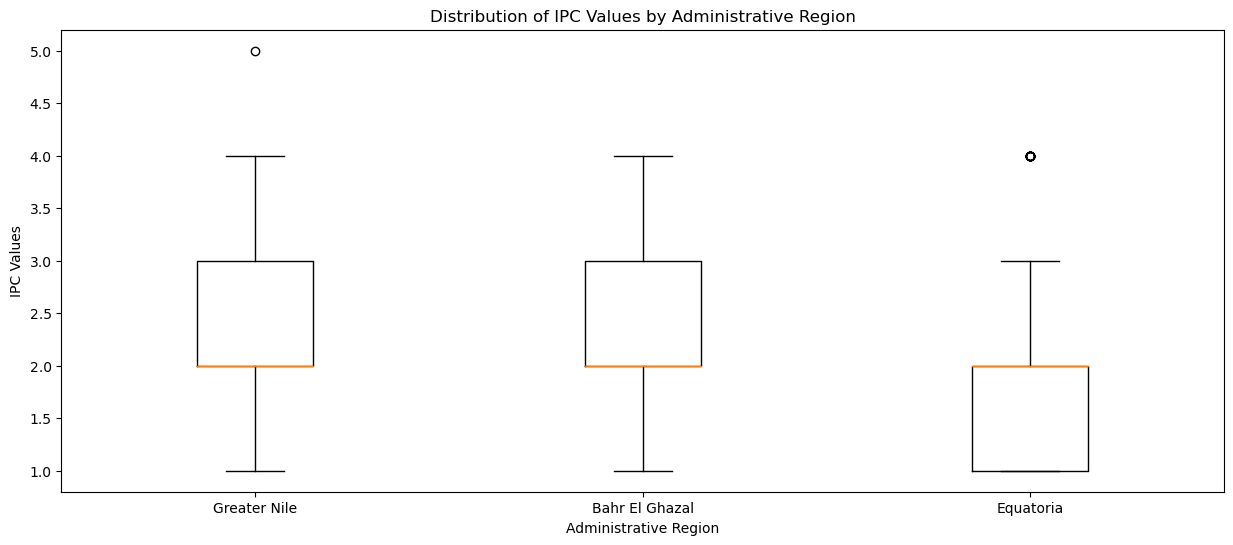

In [25]:
# Data for boxplots
ipc_data = [predicted_df_nile['ipc'].dropna(), predicted_df_bahr['ipc'].dropna(), predicted_df_equatoria['ipc'].dropna()]
labels = ['Greater Nile', 'Bahr El Ghazal', 'Equatoria']

# Create a figure and axis for the plot
plt.figure(figsize=(15, 6))

# Create boxplots for IPC values in predicted_df_nile, predicted_df_bahr, and predicted_df_equatoria to see distribution of scores within each region
plt.boxplot(ipc_data, labels=labels)
plt.xlabel('Administrative Region')
plt.ylabel('IPC Values')
plt.title('Distribution of IPC Values by Administrative Region')
plt.show()


In [26]:
# Data for the metrics, creating lists for each of the evaluation metrics - MSE, RMSE, MAE, R^2 values
regions = ['Greater Upper Nile', 'Bahr El Ghazal', 'Equatoria', 'Overall country']
mse_values = [0.46653116, 0.31719658, 0.25961473,0.34778082]
rmse_values = [0.68303087, 0.56320208, 0.50952402,0.58525232]
mae_values = [0.55756985, 0.44503211, 0.41667474,0.47309223]
r2_values = [0.40371784, 0.52414079, 0.58538598,0.50441487]

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Region': regions,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'MAE': mae_values,
    'R-squared': r2_values,
})

# Print the DataFrame
metrics_df.head()

,Region,MSE,RMSE,MAE,R-squared
0,Greater Upper Nile,0.466531,0.683031,0.557570,0.403718
1,Bahr El Ghazal,0.317197,0.563202,0.445032,0.524141
2,Equatoria,0.259615,0.509524,0.416675,0.585386
3,Overall country,0.347781,0.585252,0.473092,0.504415


Utilising the last row's values to compare regression imputation's performance with other imputation strategy values.

### Overall Country Evaluation Metrics in Relation to Contributing Regions:
**Mean Squared Error (MSE)**: The Overall Country MSE of 0.348 falls between the MSE values of Greater Upper Nile (0.467) and Equatoria (0.260), indicating a moderate prediction error. Bahr El Ghazal (0.317) shows a similar level to the Overall Country.

**Root Mean Squared Error (RMSE)**:The Overall Country RMSE of 0.585 falls within the range of Greater Upper Nile (0.683) and Equatoria (0.510). This suggests a reasonable average deviation of predicted values from actual values. Bahr El Ghazal (0.563) aligns closely with the Overall Country.

**Mean Absolute Error (MAE)**: The Overall Country MAE of 0.473 falls within the range of Greater Upper Nile (0.558) and Equatoria (0.417). This indicates a moderate absolute prediction error. Bahr El Ghazal (0.445) again aligns closely with the Overall Country.

**R-squared (R²)**:The Overall Country R-squared value of 0.504 indicates that the model explains approximately 50.4% of the variance in the target variable. This falls within the range of Bahr El Ghazal (0.524) and Greater Upper Nile (0.404), suggesting a consistent level of explanatory power. Equatoria (0.585) shows the highest explanatory power among the regions

In [27]:
# Combine the DataFrames vertically
new_df = pd.concat([predicted_df_nile, predicted_df_bahr, predicted_df_equatoria], axis=0)

# Reset the index for the combined DataFrame
new_df.reset_index(drop=True, inplace=True)

print(new_df['ipc'].describe())

count    3042.000000
mean        2.124918
std         0.896948
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: ipc, dtype: float64


In [28]:
# Check for missing values in the DataFrame
missing_values = new_df.isnull().any()

# Print columns with missing values
print('Columns with missing values:')
print(missing_values[missing_values])  # Print only columns with missing values

Columns with missing values:
ha    True
dtype: bool


The only column now with missing data is ha (Humanitarian aid). Thus, the key variable has been fully imputed.

In [29]:
# Save the modified DataFrame to a CSV file
new_df.to_csv('data/food_crises_reg_imputed.csv', index=False)

## IPC Generalization over administrative regions - using weighted mean 

For IPC GENERALIZATION over administrative regions, we need to implement the following tasks:
1. Check for dynamic changing of the area and population of the regions (from 2009)
2. Implement strategy 1: Population wise generalization
3. Implement strategy 2: Population density wise generalization

### Check for dynamic changing of the districts, area and population of the regions (from 2009)

In [30]:
# checking for number of districts under each region for each year starting 2009
def count_unique_district_codes(df, administrative_region, start_year, end_year):
    """
    Calculate the number of unique district codes for a specified administrative region
    and a range of years.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    administrative_region (str): Administrative region (e.g., 'Greater Upper Nile').
    start_year (int): Start year.
    end_year (int): End year.

    Returns:
    pd.DataFrame: DataFrame with 'Year' and 'Unique District Codes' columns.
    """
    results = []

    for year in range(start_year, end_year + 1):
        # Filter the DataFrame for the specified region and year
        filtered_df = df[(df['administrative_region'] == administrative_region) & (df['year'] == year)]

        # Count the number of unique district codes for the specified region and year
        num_unique_district_codes = filtered_df['district_code'].nunique()

        # Append the results to the list
        results.append({'Year': year, 'Unique District Codes': num_unique_district_codes})

    return pd.DataFrame(results)

regions = ['Greater Upper Nile', 'Bahr El Ghazal', 'Equatoria']
start_year = 2009
end_year = 2023

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Region', 'Year', 'Unique District Codes'])

for region in regions:
    district_counts = count_unique_district_codes(new_df, region, start_year, end_year)
    district_counts['Region'] = region
    result_df = pd.concat([result_df, district_counts], ignore_index=True)

# Print the resulting DataFrame
result_df.head()


,Region,Year,Unique District Codes
0,Greater Upper Nile,2009,32
1,Greater Upper Nile,2010,32
2,Greater Upper Nile,2011,32
3,Greater Upper Nile,2012,32
4,Greater Upper Nile,2013,32


From the output above, we can see that the districts under each region apparently do not change over the years according to the data given. The reason for checking this is that prior research showed that the districts and the area under each administrative region in South Sudan has been changing over the years due to social and political changes in their regimes.
Our exploration shows that according to the data given, the districts stay constant over the years. Although this makes the further analysis simpler, it is also a shortcoming of the data provided and could potentially influence future analysis and subsequent aid to some regions over others. Therefore, it is recommended that when ZHL furthers their research, they account for district-related changes.


### Checking if any of the administrative regions have overlap with any other region for each year of the data available:

In [31]:
def check_district_code_overlaps(df, region1, year1, region2, year2):
    # Here, you'll need to implement the logic to check if district codes overlap
    # between the specified regions and years. Return True or False accordingly.
    # For simplicity, let's assume overlap is always False for now.
    overlap = False
    return overlap

def check_overlaps_for_region_years(df, regions, start_year, end_year):
    # Initialize an empty DataFrame to store the results
    overlap_results = pd.DataFrame(columns=['Region1', 'Year1', 'Region2', 'Year2', 'Overlap'])

    # Iterate through all combinations of regions and years
    for i in range(len(regions)):
        for j in range(i + 1, len(regions)):
            region1 = regions[i]
            region2 = regions[j]

            for year1 in range(start_year, end_year + 1):
                for year2 in range(year1 + 1, end_year + 1):
                    overlap = check_district_code_overlaps(df, region1, year1, region2, year2)
                    overlap_results = overlap_results.append({
                        'Region1': region1,
                        'Year1': year1,
                        'Region2': region2,
                        'Year2': year2,
                        'Overlap': overlap
                    }, ignore_index=True)

    return overlap_results

# Example usage
regions = ['Greater Upper Nile', 'Bahr El Ghazal', 'Equatoria']
start_year = 2009
end_year = 2023

# Call the function and store the results in a DataFrame
overlap_results_df = check_overlaps_for_region_years(new_df, regions, start_year, end_year)

# Display the results
overlap_results_df.head(10)

/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/1386748891.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_results = overlap_results.append({
/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/1386748891.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_results = overlap_results.append({
/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/1386748891.py:21: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  overlap_results = overlap_results.append({
/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/1386748891.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/1386748891.py:21: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  overlap_results = overlap_results.append({
/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/1386748891.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_results = overlap_results.append({
/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/1386748891.py:21: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  overlap_results = overlap_results.append({
/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_29132/1386748891.py:21: FutureWarning: The frame.append method is deprecated a

,Region1,Year1,Region2,Year2,Overlap
0,Greater Upper Nile,2009,Bahr El Ghazal,2010,False
1,Greater Upper Nile,2009,Bahr El Ghazal,2011,False
2,Greater Upper Nile,2009,Bahr El Ghazal,2012,False
3,Greater Upper Nile,2009,Bahr El Ghazal,2013,False
4,Greater Upper Nile,2009,Bahr El Ghazal,2014,False
5,Greater Upper Nile,2009,Bahr El Ghazal,2015,False
6,Greater Upper Nile,2009,Bahr El Ghazal,2016,False
7,Greater Upper Nile,2009,Bahr El Ghazal,2017,False
8,Greater Upper Nile,2009,Bahr El Ghazal,2018,False
9,Greater Upper Nile,2009,Bahr El Ghazal,2019,False


In [32]:
# Filter and print only the rows with TRUE overlap
overlap_true_df = overlap_results_df[overlap_results_df['Overlap']]
print(overlap_true_df)

Empty DataFrame
Columns: [Region1, Year1, Region2, Year2, Overlap]
Index: []


#### From this we can conclude that the districts that fall under each region do not dynamically change as per the data provided. That is, there is no overlap between any of the districts that fall under a region in a year with another region in any other year

In [33]:
print(new_df[['district_code', 'administrative_region', 'ipc', 'pop', 'year', 'area', 'month']].head(10))

   district_code administrative_region  ipc       pop  year      area  month
0             74    Greater Upper Nile  2.0  256618.0  2009  14008.33      7
1             74    Greater Upper Nile  2.0  256618.0  2009  14008.33     10
2             74    Greater Upper Nile  1.0  265263.0  2010  14008.33      1
3             74    Greater Upper Nile  2.0  265263.0  2010  14008.33      4
4             74    Greater Upper Nile  2.0  265263.0  2010  14008.33      7
5             74    Greater Upper Nile  2.0  265263.0  2010  14008.33     10
6             74    Greater Upper Nile  1.0  271467.0  2011  14008.33      1
7             74    Greater Upper Nile  1.0  271467.0  2011  14008.33      4
8             74    Greater Upper Nile  2.0  271467.0  2011  14008.33      7
9             74    Greater Upper Nile  1.0  271467.0  2011  14008.33     10


In [34]:
# Group by year, month, and district code and check if population is constant within each group
population_consistency_by_district = new_df.groupby(['year', 'month', 'district_code'])['pop'].nunique()

# Check if all values are 1, indicating consistent population for each year's months within each district
consistent_population_by_district = population_consistency_by_district[population_consistency_by_district == 1].index

# Invert the condition to get inconsistent cases
inconsistent_population_by_district = population_consistency_by_district[population_consistency_by_district != 1].index

# Print the inconsistent population years and district codes
print("Years with inconsistent population for some months by district code:")
print(inconsistent_population_by_district)
# if empty variable then prints nothing 

Years with inconsistent population for some months by district code:
MultiIndex([], names=['year', 'month', 'district_code'])


**The output above shows that the population appears to be constant for each district code within the same year for all months. That is, in a year, the population for each district does not change. This means the data given does not account for migration (internally or externally). -> Tip for ZHL to consider and include migration data when using population as a measure of/ contributor of the analysis**

In [35]:
# Group by year, month, and administrative region and sum up the population
total_population_by_region = new_df.groupby(['year', 'month', 'administrative_region'])['pop'].sum().reset_index()

# Filter for the specified regions
specified_regions = ['Greater Upper Nile', 'Bahr El Ghazal', 'Equatoria']
total_population_specified_regions = total_population_by_region[total_population_by_region['administrative_region'].isin(specified_regions)]

# Print the first 10 rows to verify
print(total_population_specified_regions.head(10))

   year  month administrative_region        pop
0  2009      7        Bahr El Ghazal  3036461.0
1  2009      7             Equatoria  3284728.0
2  2009      7    Greater Upper Nile  3394056.0
3  2009     10        Bahr El Ghazal  3036461.0
4  2009     10             Equatoria  3284728.0
5  2009     10    Greater Upper Nile  3394056.0
6  2010      1        Bahr El Ghazal  3075566.0
7  2010      1             Equatoria  3518082.0
8  2010      1    Greater Upper Nile  3514041.0
9  2010      4        Bahr El Ghazal  3075566.0


The output above shows the total population f all the 3 regions Greater Upper Nile, Bahr El Ghazal, and Equatoria by summing up the population of the districts that fall under them respectively for each month and year specifically

In [36]:
# Merge the DataFrames based on 'year', 'month', and 'administrative_region'
new_df = new_df.merge(total_population_specified_regions, on=['year', 'month', 'administrative_region'], how='left', suffixes=('', '_total'))

# Rename the 'pop_total' column to 'total_region_pop'
new_df.rename(columns={'pop_total': 'total_region_pop'}, inplace=True)

# Print the updated DataFrame
new_df[['district_code','year','month','quarters','pop','total_region_pop', 'administrative_region']]

,district_code,year,month,quarters,pop,total_region_pop,administrative_region
0,74,2009,7,2009Q3,256618.00,3394056.00,Greater Upper Nile
1,74,2009,10,2009Q4,256618.00,3394056.00,Greater Upper Nile
2,74,2010,1,2010Q1,265263.00,3514041.00,Greater Upper Nile
3,74,2010,4,2010Q2,265263.00,3514041.00,Greater Upper Nile
4,74,2010,7,2010Q3,265263.00,3514041.00,Greater Upper Nile
...,...,...,...,...,...,...,...
3037,102,2018,10,2018Q4,44350.00,4663386.00,Equatoria
3038,102,2019,2,2019Q1,34435.00,4433463.00,Equatoria
3039,102,2019,6,2019Q2,34435.00,4433463.00,Equatoria
3040,102,2019,10,2019Q4,34435.00,4433463.00,Equatoria


### IPC GENERALIZATION  STRATEGY #1 - POPULATION-WISE WEIGHTED MEAN

In [37]:
# Normalize population to sum up to 1 (weights should be proportions)
new_df['normalized_population'] = new_df['pop'] / new_df['total_region_pop']

# Calculate the weighted IPC using normalized population as weights
new_df['weighted_ipc_pop'] = new_df['ipc'] * new_df['normalized_population']

# new_df[['district_code','year','month','quarters','ipc','pop','total_region_pop', 'administrative_region', 'normalized_population','weighted_ipc_pop']]

# Group by year, month, and administrative region to find the weighted mean IPC
weighted_ipc_by_region_population = new_df.groupby(['year', 'month', 'administrative_region'])['weighted_ipc_pop'].sum().reset_index()

# Print the updated DataFrame
print(weighted_ipc_by_region_population)

     year  month administrative_region  weighted_ipc_pop
0    2009      7        Bahr El Ghazal          1.897398
1    2009      7             Equatoria          1.386920
2    2009      7    Greater Upper Nile          1.902810
3    2009     10        Bahr El Ghazal          2.051824
4    2009     10             Equatoria          1.553235
..    ...    ...                   ...               ...
112  2019     10             Equatoria          2.370201
113  2019     10    Greater Upper Nile          3.133691
114  2020      2        Bahr El Ghazal          3.013384
115  2020      2             Equatoria          3.133193
116  2020      2    Greater Upper Nile          3.397920

[117 rows x 4 columns]


In [38]:
# Calculate the denominator: Sum of weights (sum of normalized populations) for each region and time period
denominator_df = new_df.groupby(['year', 'month', 'administrative_region'])['normalized_population'].sum().reset_index()
denominator_df.rename(columns={'normalized_population': 'total_weight'}, inplace=True)

# Merge the numerator (weighted IPC) and denominator (sum of weights) DataFrames
ipc_by_region = weighted_ipc_by_region_population.merge(denominator_df, on=['year', 'month', 'administrative_region'])

# Calculate the generalized IPC score per region
ipc_by_region['generalized_ipc_pop'] = ipc_by_region['weighted_ipc_pop'] / ipc_by_region['total_weight']

# Merge the generalized IPC scores back into the new_df DataFrame
new_df = new_df.merge(ipc_by_region[['year', 'month', 'administrative_region', 'generalized_ipc_pop']],
                      on=['year', 'month', 'administrative_region'], how='left')

# Print the updated DataFrame with the generalized IPC scores
new_df.head()

,Unnamed: 0,country,district_code,district,centx,centy,year,month,ipc,ha,...,pop,ruggedness_mean,pasture_pct,date,administrative_region,quarters,total_region_pop,normalized_population,weighted_ipc_pop,generalized_ipc_pop
0,30,South Sudan,74,Bor,32.00486,6.465644,2009,7,2.0,NaN,...,256618.0,11393.76,90.8503,2009-07-01,Greater Upper Nile,2009Q3,3394056.0,0.075608,0.151216,1.902810
1,33,South Sudan,74,Bor,32.00486,6.465644,2009,10,2.0,NaN,...,256618.0,11393.76,90.8503,2009-10-01,Greater Upper Nile,2009Q4,3394056.0,0.075608,0.151216,1.961599
2,36,South Sudan,74,Bor,32.00486,6.465644,2010,1,1.0,NaN,...,265263.0,11393.76,90.8503,2010-01-01,Greater Upper Nile,2010Q1,3514041.0,0.075487,0.075487,1.408736
3,39,South Sudan,74,Bor,32.00486,6.465644,2010,4,2.0,NaN,...,265263.0,11393.76,90.8503,2010-04-01,Greater Upper Nile,2010Q2,3514041.0,0.075487,0.150973,1.686282
4,42,South Sudan,74,Bor,32.00486,6.465644,2010,7,2.0,NaN,...,265263.0,11393.76,90.8503,2010-07-01,Greater Upper Nile,2010Q3,3514041.0,0.075487,0.150973,1.860796


The output above is for the weighted IPC scores just on the basis of population per district in a region for the respective years and months.
Weighted IPC values are in float

In [39]:
# Save the modified DataFrame to a CSV file if you want to save just the IPC's generalised by populated weighted mean
# new_df.to_csv('data/weighted_ipc_population_per_region.csv', index=False)

### IPC GENERALIZATION STRATEGY #2 - POPULATION DENSITY WISE WEIGHTED MEAN


In [40]:
# The unit of area in the data is in sq. mts so we need to first change it to km^2
# Calculate population density for each district in square kilometers
new_df['pop_density'] = new_df['pop'] / (new_df['area'] / 1_000_000)  # Convert area to square kilometers

# Calculate the weighted IPC using population density as weights
new_df['weighted_ipc_density'] = new_df['ipc'] * new_df['pop_density']

# Group by year, month, and administrative region to find the weighted mean IPC using population density as weights
weighted_ipc_by_region_density = new_df.groupby(['year', 'month', 'administrative_region'])['weighted_ipc_density'].sum().reset_index()

# Print the updated DataFrame
print(weighted_ipc_by_region_density)

     year  month administrative_region  weighted_ipc_density
0    2009      7        Bahr El Ghazal          1.100583e+09
1    2009      7             Equatoria          8.934580e+08
2    2009      7    Greater Upper Nile          1.300455e+09
3    2009     10        Bahr El Ghazal          1.194384e+09
4    2009     10             Equatoria          1.008934e+09
..    ...    ...                   ...                   ...
112  2019     10             Equatoria          1.911751e+09
113  2019     10    Greater Upper Nile          3.213317e+09
114  2020      2        Bahr El Ghazal          1.502122e+09
115  2020      2             Equatoria          5.146602e+09
116  2020      2    Greater Upper Nile          2.847686e+09

[117 rows x 4 columns]


In [41]:
# Calculate the denominator: Sum of weights (sum of population densities) for each region and time period
denominator_density_df = new_df.groupby(['year', 'month', 'administrative_region'])['pop_density'].sum().reset_index()
denominator_density_df.rename(columns={'pop_density': 'total_weight_density'}, inplace=True)

# Merge the numerator (weighted IPC) and denominator (sum of weights) DataFrames
ipc_by_region_density = weighted_ipc_by_region_density.merge(denominator_density_df, on=['year', 'month', 'administrative_region'])

# Calculate the generalized IPC score per region using population density as weights
ipc_by_region_density['generalized_ipc_density'] = ipc_by_region_density['weighted_ipc_density'] / ipc_by_region_density['total_weight_density']

# Merge the generalized IPC scores back into the new_df DataFrame
new_df = new_df.merge(ipc_by_region_density[['year', 'month', 'administrative_region', 'generalized_ipc_density']],
                      on=['year', 'month', 'administrative_region'], how='left')

# Print the updated DataFrame with the generalized IPC scores using population density as weights
new_df.head()

,Unnamed: 0,country,district_code,district,centx,centy,year,month,ipc,ha,...,date,administrative_region,quarters,total_region_pop,normalized_population,weighted_ipc_pop,generalized_ipc_pop,pop_density,weighted_ipc_density,generalized_ipc_density
0,30,South Sudan,74,Bor,32.00486,6.465644,2009,7,2.0,NaN,...,2009-07-01,Greater Upper Nile,2009Q3,3394056.0,0.075608,0.151216,1.902810,1.831896e+07,3.663791e+07,1.840095
1,33,South Sudan,74,Bor,32.00486,6.465644,2009,10,2.0,NaN,...,2009-10-01,Greater Upper Nile,2009Q4,3394056.0,0.075608,0.151216,1.961599,1.831896e+07,3.663791e+07,1.630804
2,36,South Sudan,74,Bor,32.00486,6.465644,2010,1,1.0,NaN,...,2010-01-01,Greater Upper Nile,2010Q1,3514041.0,0.075487,0.075487,1.408736,1.893609e+07,1.893609e+07,1.324514
3,39,South Sudan,74,Bor,32.00486,6.465644,2010,4,2.0,NaN,...,2010-04-01,Greater Upper Nile,2010Q2,3514041.0,0.075487,0.150973,1.686282,1.893609e+07,3.787218e+07,1.454715
4,42,South Sudan,74,Bor,32.00486,6.465644,2010,7,2.0,NaN,...,2010-07-01,Greater Upper Nile,2010Q3,3514041.0,0.075487,0.150973,1.860796,1.893609e+07,3.787218e+07,1.665664


Now, we have been able to implement the IPC Generalization using 2 strategies:
1. Population wise weighted mean
2. Population density wise weighted mean

**Let's compare the values to see how the two generalization strategies are different**

In [42]:
new_df[['district_code','administrative_region','quarters','ipc','generalized_ipc_pop','generalized_ipc_density']].head(10)

,district_code,administrative_region,quarters,ipc,generalized_ipc_pop,generalized_ipc_density
0,74,Greater Upper Nile,2009Q3,2.0,1.902810,1.840095
1,74,Greater Upper Nile,2009Q4,2.0,1.961599,1.630804
2,74,Greater Upper Nile,2010Q1,1.0,1.408736,1.324514
3,74,Greater Upper Nile,2010Q2,2.0,1.686282,1.454715
4,74,Greater Upper Nile,2010Q3,2.0,1.860796,1.665664
5,74,Greater Upper Nile,2010Q4,2.0,1.874042,1.923495
6,74,Greater Upper Nile,2011Q1,1.0,1.468206,1.645221
7,74,Greater Upper Nile,2011Q2,1.0,1.693706,1.850816
8,74,Greater Upper Nile,2011Q3,2.0,2.293207,2.228154
9,74,Greater Upper Nile,2011Q4,1.0,1.669664,1.418533


When looking at the values very breifly, we can tell that although very close, the values resulting from the weighted mean of population density are slightly lower than the population weighted mean.

Next task: create a df of the year, month, quarter, region, generalized ipc pop, generalized ipc density

In [43]:
# Save the modified DataFrame to a CSV file contains both the implementation of both IPC generalisation strategies (by population, and population density_
new_df.to_csv('data/generalised_ipc.csv', index=False)